In [1]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session


In [2]:
bucket_name = 'hemanta221s3bucket' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [3]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [4]:
# set an output path where the trained model will be saved
prefix = 'xgboost-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://hemanta221s3bucket/xgboost-as-a-built-in-algo/output


In [5]:
!pip install -q kaggle

In [6]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/home/ec2-user/.kaggle’: File exists


In [7]:
!touch ~/.kaggle/kaggle.json

In [8]:
api_token = {"username":"hemantarijal","key":"293105a79539c7b29cdcf4561008dee2"}

In [9]:
!chmod 600 ~/.kaggle/kaggle.json


In [11]:
import os
import json

config_path = os.path.expanduser('~/.kaggle/kaggle.json')

with open(config_path, 'w') as file:
    json.dump(api_token,file)


In [12]:
with open(config_path, 'r') as file:
    print(file.read())

{"username": "hemantarijal", "key": "293105a79539c7b29cdcf4561008dee2"}


In [13]:
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d rinichristy/2022-fuel-consumption-ratings --force

  0%|                                               | 0.00/13.4k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 13.4k/13.4k [00:00<00:00, 24.3MB/s]


In [15]:
ls

2022-fuel-consumption-ratings.zip  kaggle/      test.csv   Untitled.ipynb
data/                              lost+found/  train.csv


In [16]:
import zipfile
with zipfile.ZipFile('./2022-fuel-consumption-ratings.zip','r') as zip_ref:
    zip_ref.extractall('./data')

In [17]:
#load data into dataframe 
import pandas as pd


In [18]:
try:
    data = pd.read_csv('./data/MY2022 Fuel Consumption Ratings.csv',index_col=0)
    print('data loaded into dataframe')
except Exception as e:
    print('Import error: ',e)
    

data loaded into dataframe


In [19]:
data.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km),CO2 Rating,Smog Rating
Model Year,,,,,,,,,,,,,,
2022,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200,6,3
2022,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,5
2022,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6
2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242,5,6
2022,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230,5,7


In [20]:
# data exploration

In [21]:
#shape of the data
print("shape of data")
data.shape

shape of data


(946, 14)

In [22]:
#checking the unique value from columns
data.nunique()

Make                                  39
Model                                715
Vehicle Class                         14
Engine Size(L)                        36
Cylinders                              8
Transmission                          23
Fuel Type                              4
Fuel Consumption (City (L/100 km)    149
Fuel Consumption(Hwy (L/100 km))     107
Fuel Consumption(Comb (L/100 km))    131
Fuel Consumption(Comb (mpg))          49
CO2 Emissions(g/km)                  242
CO2 Rating                            10
Smog Rating                            5
dtype: int64

In [23]:
# we dont need model year in the value since all of  this data from 2014.
data = data.drop(['Model'],axis=1)

In [24]:
data.isnull().sum()

Make                                 0
Vehicle Class                        0
Engine Size(L)                       0
Cylinders                            0
Transmission                         0
Fuel Type                            0
Fuel Consumption (City (L/100 km)    0
Fuel Consumption(Hwy (L/100 km))     0
Fuel Consumption(Comb (L/100 km))    0
Fuel Consumption(Comb (mpg))         0
CO2 Emissions(g/km)                  0
CO2 Rating                           0
Smog Rating                          0
dtype: int64

In [25]:
data.describe()

,Engine Size(L),Cylinders,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km),CO2 Rating,Smog Rating
count,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000
mean,3.198732,5.668076,12.506448,9.363319,11.092072,27.247357,259.172304,4.539112,4.950317
std,1.374814,1.932670,3.452043,2.285125,2.876276,7.685217,64.443149,1.471799,1.679842
min,1.200000,3.000000,4.000000,3.900000,4.000000,11.000000,94.000000,1.000000,1.000000
25%,2.000000,4.000000,10.200000,7.700000,9.100000,22.000000,213.250000,3.000000,3.000000
50%,3.000000,6.000000,12.200000,9.200000,10.800000,26.000000,257.000000,5.000000,5.000000
75%,3.800000,6.000000,14.700000,10.700000,12.900000,31.000000,300.750000,5.000000,6.000000
max,8.000000,16.000000,30.300000,20.900000,26.100000,71.000000,608.000000,10.000000,7.000000


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 946 entries, 2022 to 2022
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Make                               946 non-null    object 
 1   Vehicle Class                      946 non-null    object 
 2   Engine Size(L)                     946 non-null    float64
 3   Cylinders                          946 non-null    int64  
 4   Transmission                       946 non-null    object 
 5   Fuel Type                          946 non-null    object 
 6   Fuel Consumption (City (L/100 km)  946 non-null    float64
 7   Fuel Consumption(Hwy (L/100 km))   946 non-null    float64
 8   Fuel Consumption(Comb (L/100 km))  946 non-null    float64
 9   Fuel Consumption(Comb (mpg))       946 non-null    int64  
 10  CO2 Emissions(g/km)                946 non-null    int64  
 11  CO2 Rating                         946 non-null    int64  


In [27]:
data.rename(columns = {
                        'CO2 Emissions(g/km)':'C02emissions',
                        'Vehicle Class':'VehicleClass',
                        'Engine Size(L)':'EngineSize',
                        'Fuel Type':'FuelType',
                        'Fuel Consumption (City (L/100 km)':'FuelConsumptionCity',
                        'Fuel Consumption(Hwy (L/100 km))':'FuelConsumptionHwy',
                        'Fuel Consumption(Comb (L/100 km))':'FuelConsumptionComb',
                        'Fuel Consumption(Comb (mpg))':'FuelConsumptionCombMpg',
                        'CO2 Rating':'C02Rating',
                        'Smog Rating':'smogRating'
                      }, inplace = True)

In [28]:

data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 946 entries, 2022 to 2022
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Make                    946 non-null    object 
 1   VehicleClass            946 non-null    object 
 2   EngineSize              946 non-null    float64
 3   Cylinders               946 non-null    int64  
 4   Transmission            946 non-null    object 
 5   FuelType                946 non-null    object 
 6   FuelConsumptionCity     946 non-null    float64
 7   FuelConsumptionHwy      946 non-null    float64
 8   FuelConsumptionComb     946 non-null    float64
 9   FuelConsumptionCombMpg  946 non-null    int64  
 10  C02emissions            946 non-null    int64  
 11  C02Rating               946 non-null    int64  
 12  smogRating              946 non-null    int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 103.5+ KB


In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/tmp/ipykernel_32579/633934980.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data['C02emissions'], kde = True, color = 'c')


Text(0.5, 1.0, 'Distribution of CO2EMISSIONS')

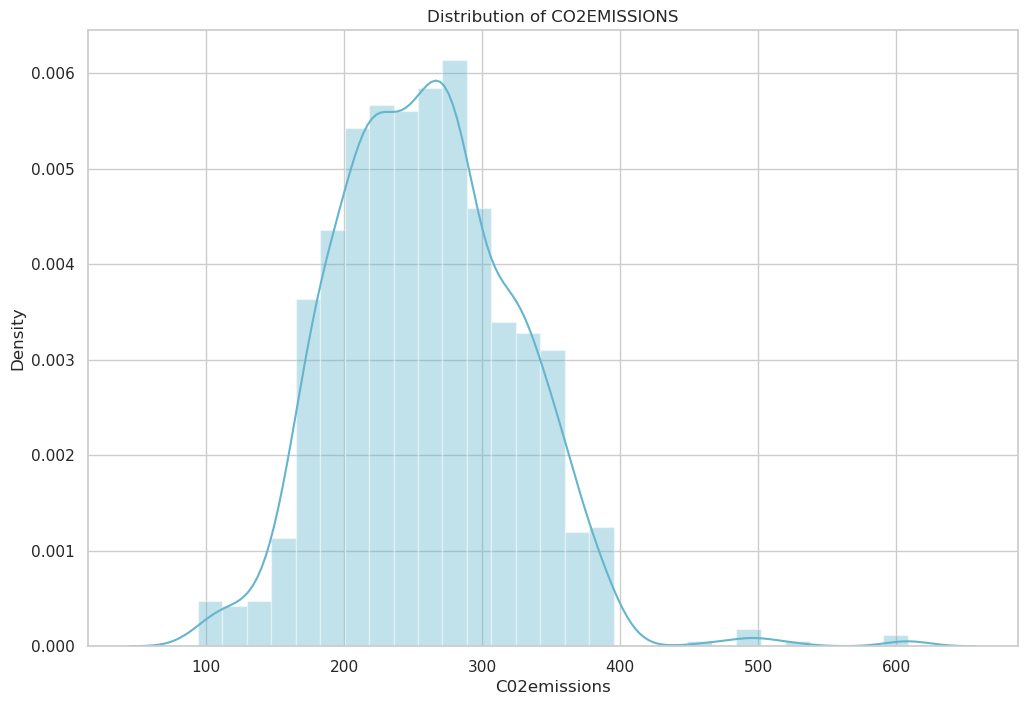

In [30]:
sns.set(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.distplot(data['C02emissions'], kde = True, color = 'c')
plt.title('Distribution of CO2EMISSIONS')

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 946 entries, 2022 to 2022
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Make                    946 non-null    object 
 1   VehicleClass            946 non-null    object 
 2   EngineSize              946 non-null    float64
 3   Cylinders               946 non-null    int64  
 4   Transmission            946 non-null    object 
 5   FuelType                946 non-null    object 
 6   FuelConsumptionCity     946 non-null    float64
 7   FuelConsumptionHwy      946 non-null    float64
 8   FuelConsumptionComb     946 non-null    float64
 9   FuelConsumptionCombMpg  946 non-null    int64  
 10  C02emissions            946 non-null    int64  
 11  C02Rating               946 non-null    int64  
 12  smogRating              946 non-null    int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 103.5+ KB


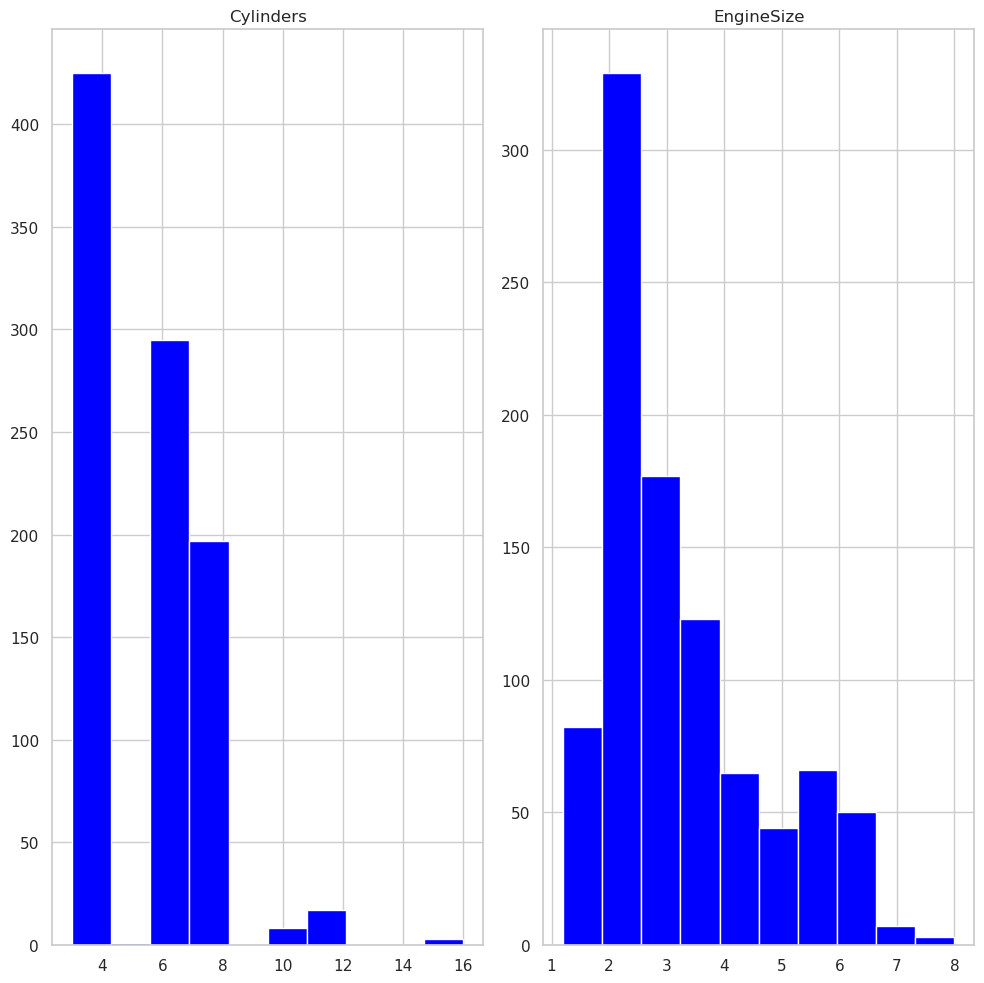

In [32]:
viz = data[['Cylinders','EngineSize']]
viz.hist(color = 'Blue', figsize = (10, 10))
plt.tight_layout();
plt.show();

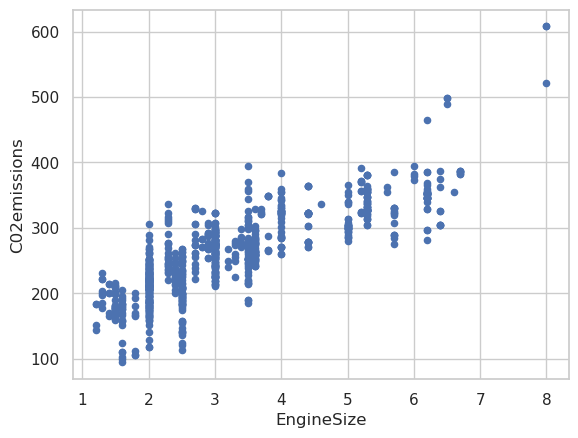

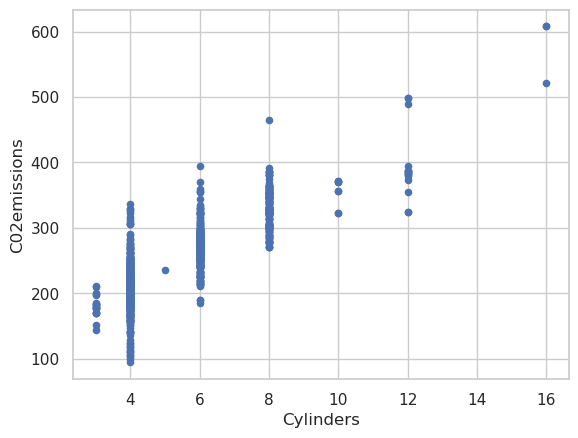

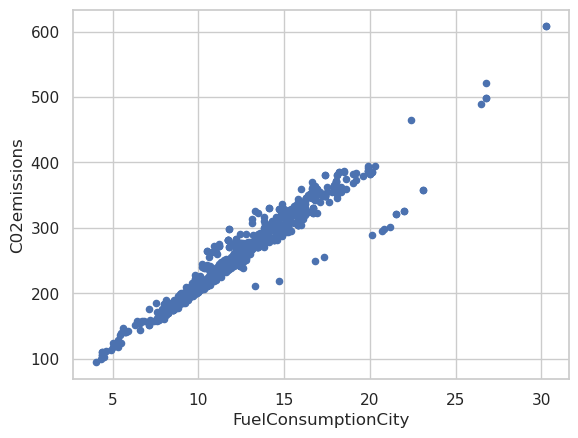

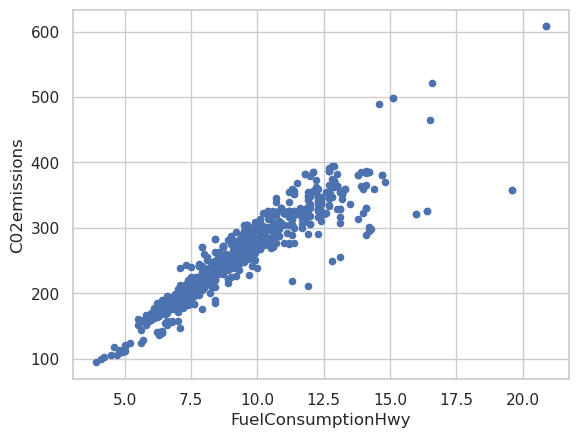

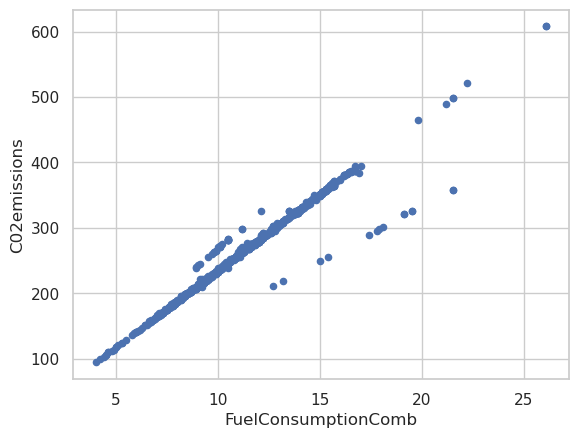

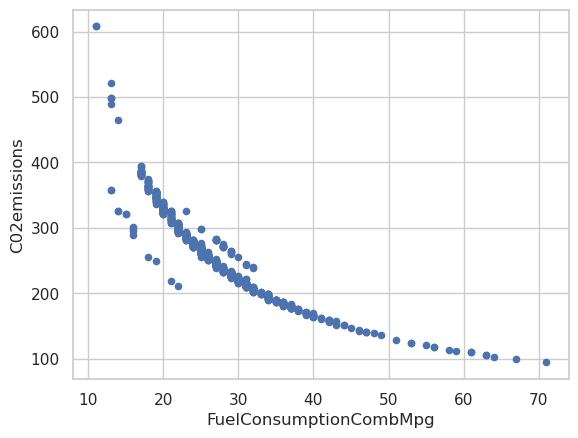

In [33]:
# this visualization helps to hind correlation between each columns
data.plot(kind='scatter', x='EngineSize', y='C02emissions')
data.plot(kind='scatter', x='Cylinders', y='C02emissions')
data.plot(kind='scatter', x='FuelConsumptionCity', y='C02emissions')
data.plot(kind='scatter', x='FuelConsumptionHwy', y='C02emissions')
data.plot(kind='scatter', x='FuelConsumptionComb', y='C02emissions')
data.plot(kind='scatter', x='FuelConsumptionCombMpg', y='C02emissions')
plt.show()

Text(0.5, 1.0, 'Carbon Emission by Make')

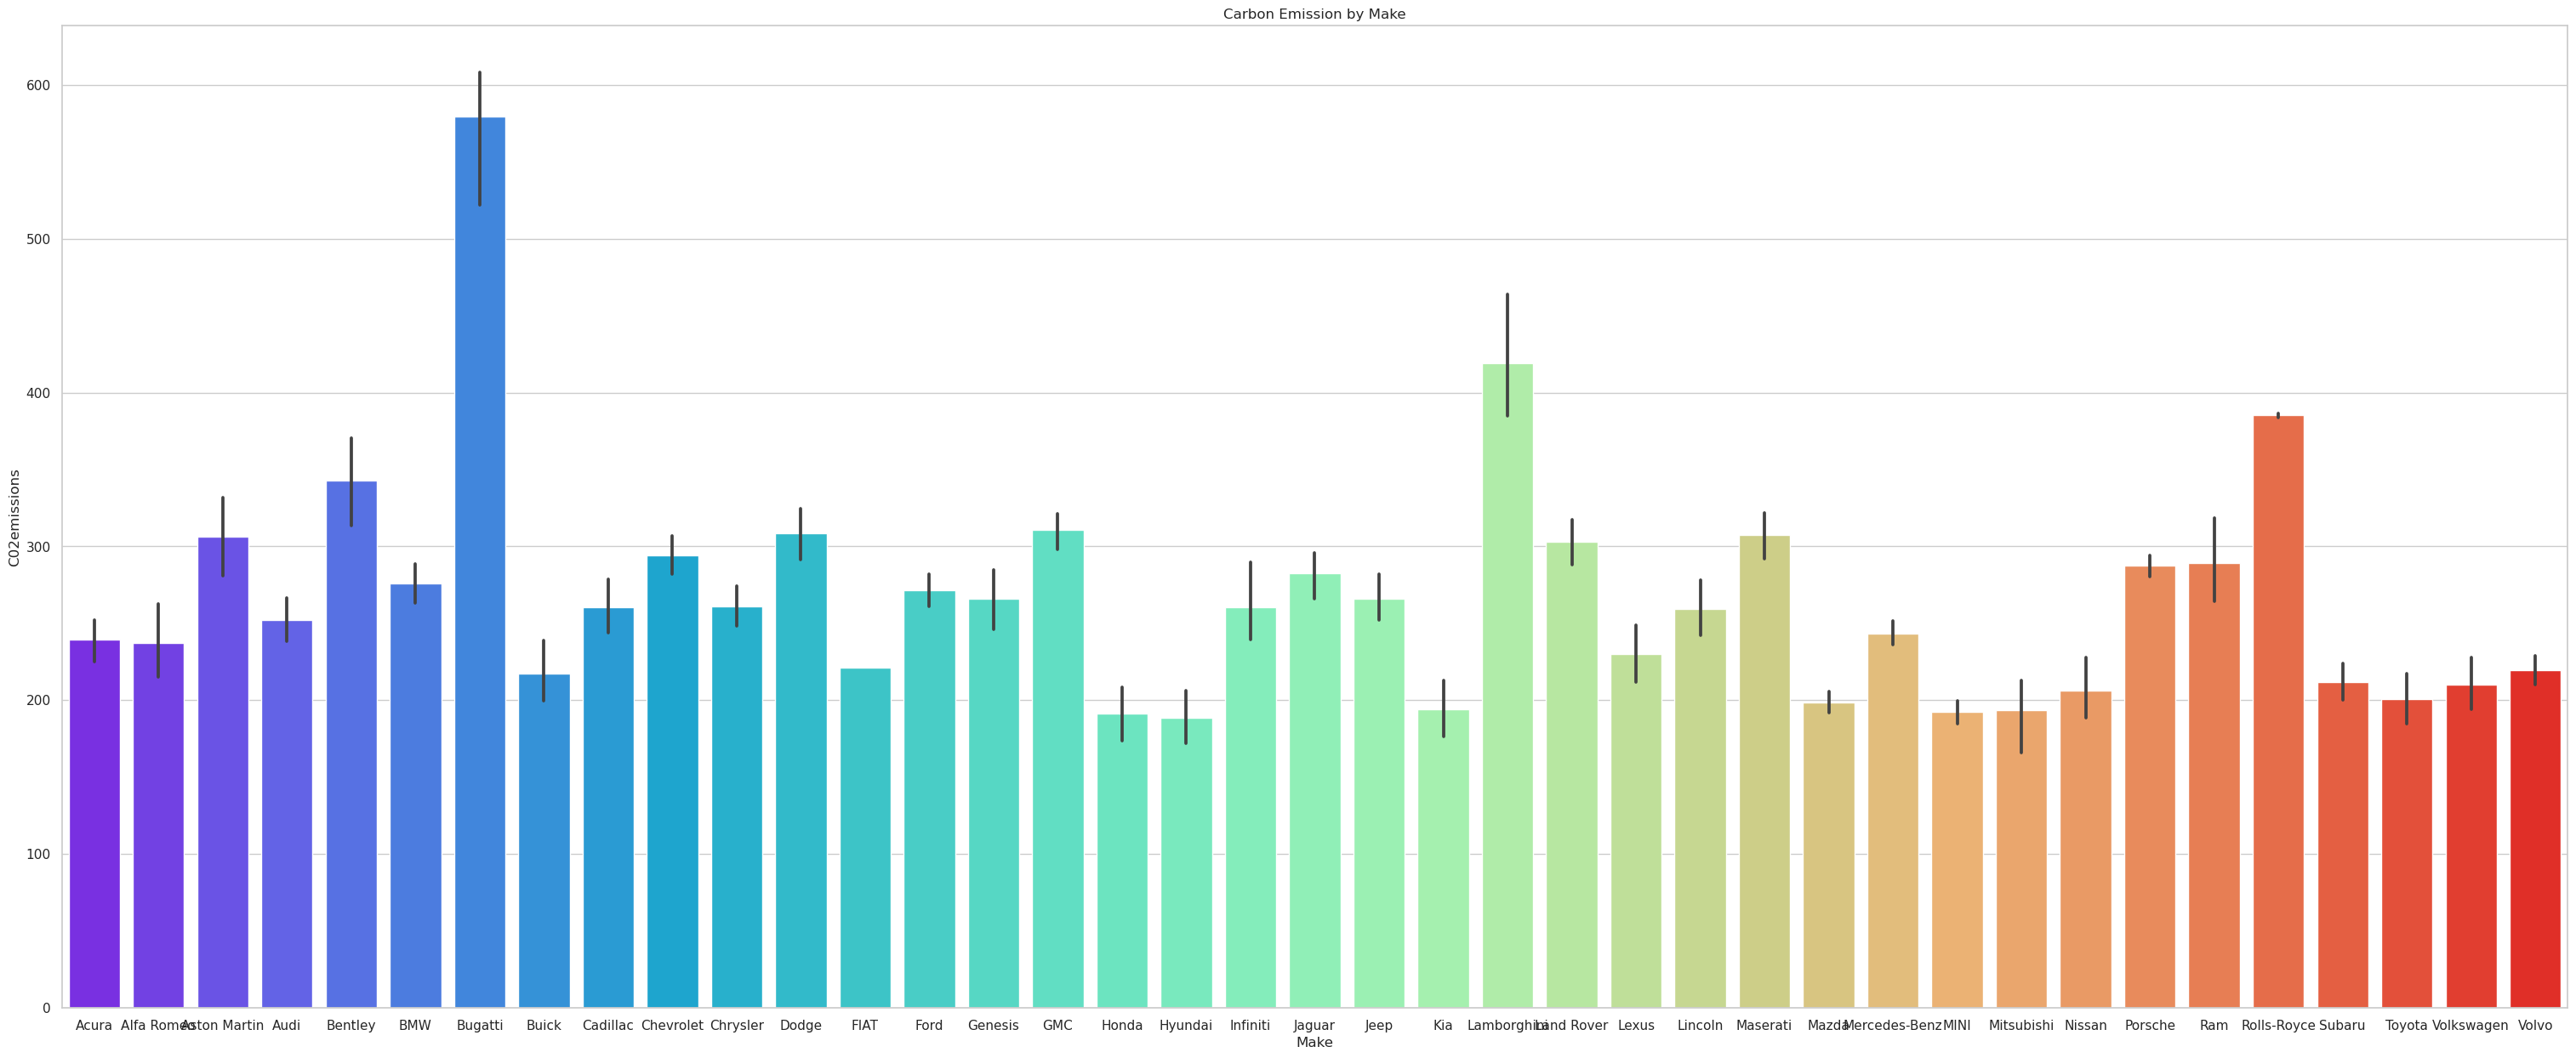

In [34]:
plt.figure(figsize=(38,15))
sns.barplot(x='Make',y='C02emissions',data=data, palette='rainbow')
plt.title("Carbon Emission by Make")

Text(0.5, 1.0, 'Carbon Emission by Make')

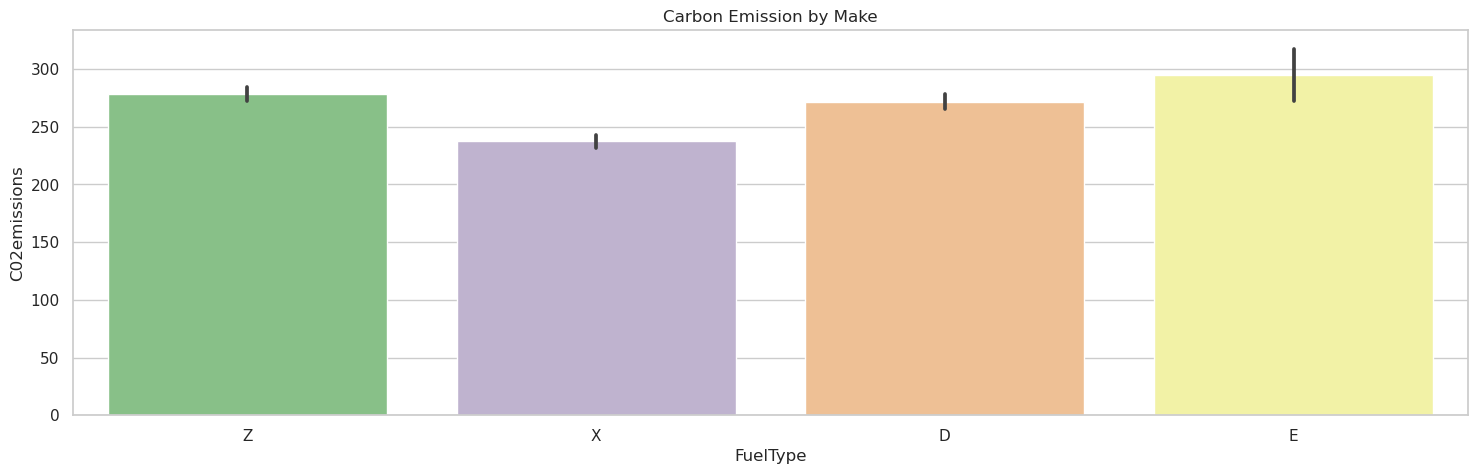

In [36]:
plt.figure(figsize=(18,5))
sns.barplot(x='FuelType',y='C02emissions',data=data, palette='Accent')
plt.title("Carbon Emission by Make")

Text(0.5, 1.0, 'Carbon Emission by Transmission')

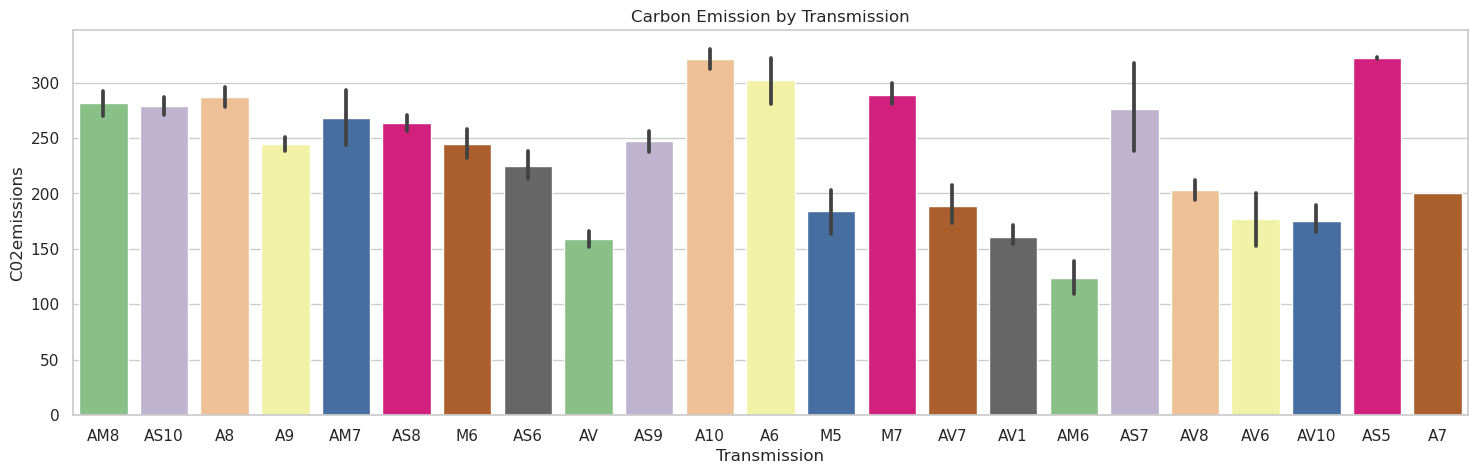

In [37]:
plt.figure(figsize=(18,5))
sns.barplot(x='Transmission',y='C02emissions',data=data, palette='Accent')
plt.title("Carbon Emission by Transmission")

Text(0.5, 1.0, 'Carbon Emission by Vehicle Class')

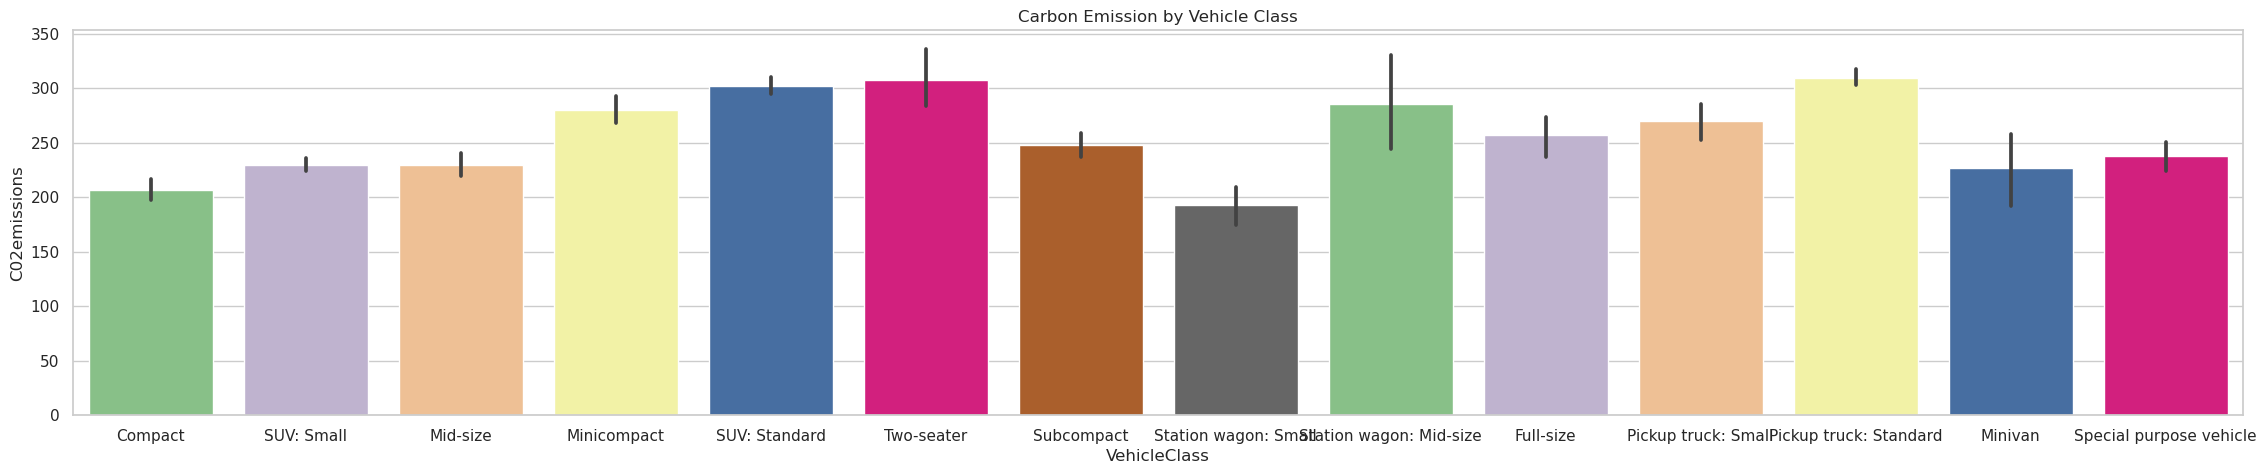

In [38]:
plt.figure(figsize=(28,5))
sns.barplot(x='VehicleClass',y='C02emissions',data=data, palette='Accent')
plt.title("Carbon Emission by Vehicle Class")

# Label Encoding

In [39]:
from sklearn.preprocessing import LabelEncoder  #encoding (we convert categorical variables into Numeric)
lb=LabelEncoder() 

In [40]:
data['FuelType']=lb.fit_transform(data['FuelType'])
data['Make']= lb.fit_transform(data['Make'])
data['VehicleClass']= lb.fit_transform(data['VehicleClass'])
data['Transmission']= lb.fit_transform(data['Transmission'])

In [41]:
data

,Make,VehicleClass,EngineSize,Cylinders,Transmission,FuelType,FuelConsumptionCity,FuelConsumptionHwy,FuelConsumptionComb,FuelConsumptionCombMpg,C02emissions,C02Rating,smogRating
Model Year,,,,,,,,,,,,,
2022,0,0,2.4,4,7,3,9.9,7.0,8.6,33,200,6,3
2022,0,7,3.5,6,8,3,12.6,9.4,11.2,25,263,4,5
2022,0,7,2.0,4,8,3,11.0,8.6,9.9,29,232,5,6
2022,0,7,2.0,4,8,3,11.3,9.1,10.3,27,242,5,6
2022,0,0,2.0,4,8,3,11.2,8.0,9.8,29,230,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022,38,7,2.0,4,12,3,10.7,7.7,9.4,30,219,5,5
2022,38,7,2.0,4,12,3,10.5,8.1,9.4,30,219,5,5
2022,38,7,2.0,4,12,3,11.0,8.7,9.9,29,232,5,7


## Finding Correleation between data

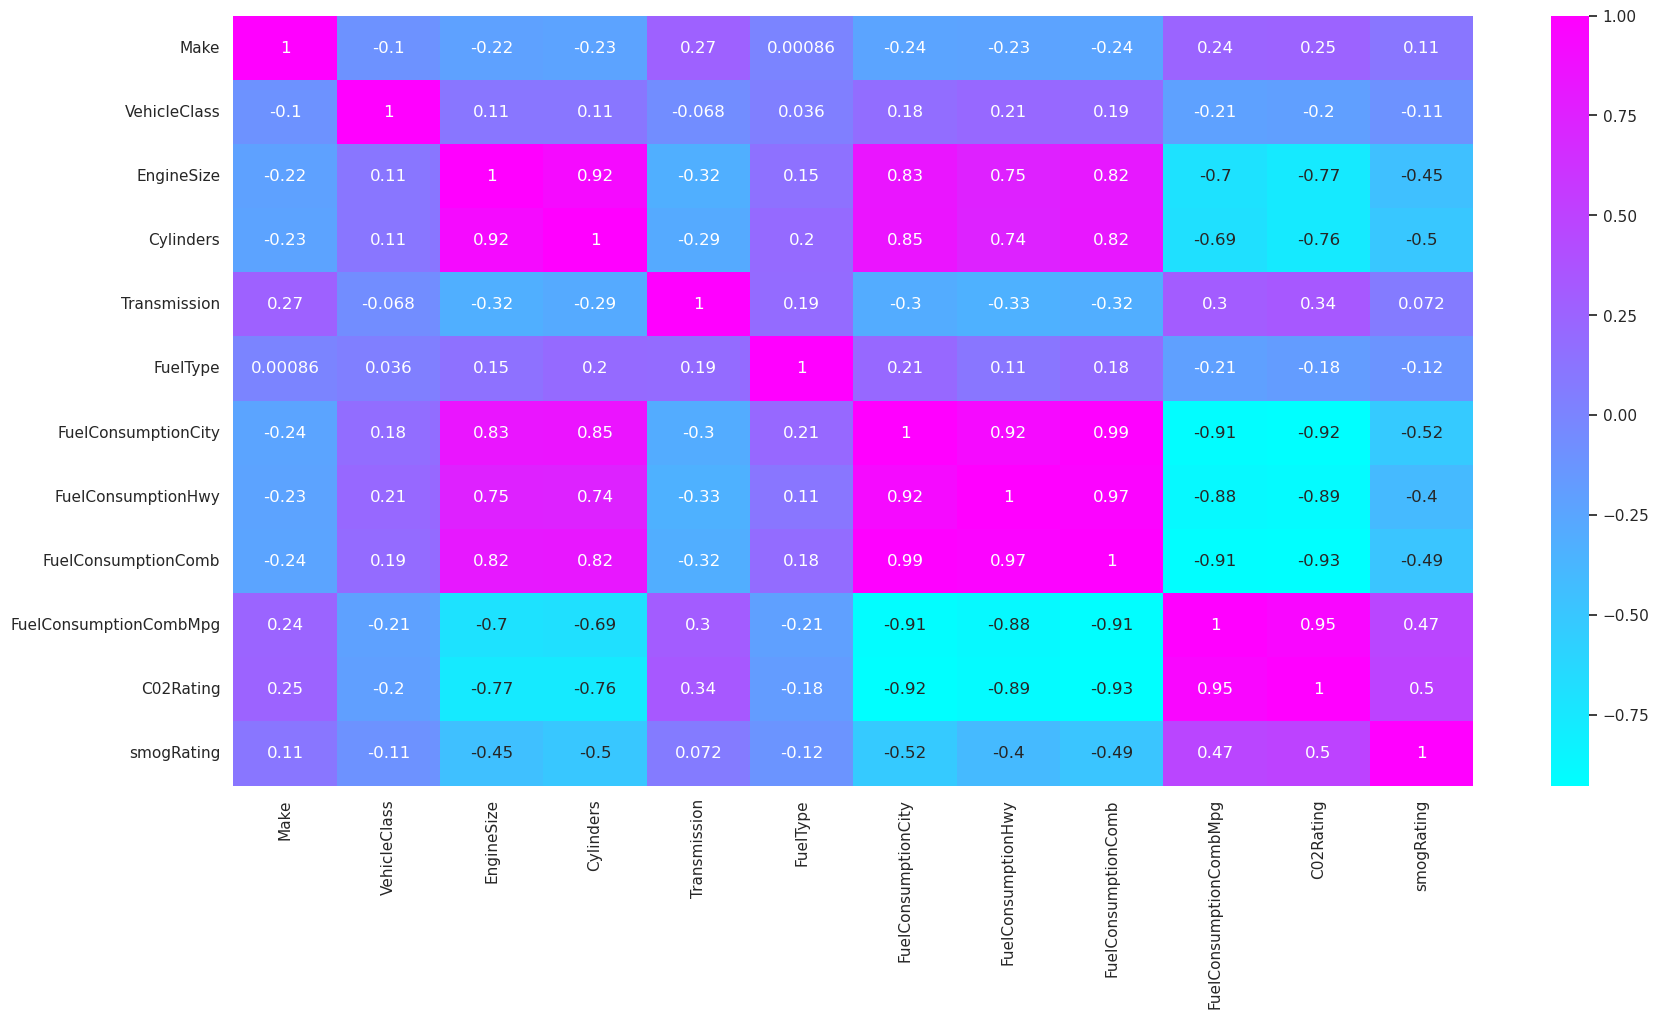

In [42]:
data2 = data.drop('C02emissions',axis='columns')
#corelation
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.heatmap(data2.corr(), annot=True, cmap='cool')

In [43]:
import numpy as np

#### We are removing the all correlation data which correlation is above 0.80

In [44]:
# Create correlation matrix
corr_matrix = data2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

to_drop

/tmp/ipykernel_32579/354430140.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['Cylinders',
 'FuelConsumptionCity',
 'FuelConsumptionHwy',
 'FuelConsumptionComb',
 'FuelConsumptionCombMpg',
 'C02Rating']

In [45]:
# col_to_drop= ['FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB','CYLINDERS'];
data = data.drop(to_drop,axis=1)

In [46]:
data.head()

,Make,VehicleClass,EngineSize,Transmission,FuelType,C02emissions,smogRating
Model Year,,,,,,,
2022,0,0,2.4,7,3,200,3
2022,0,7,3.5,8,3,263,5
2022,0,7,2.0,8,3,232,6
2022,0,7,2.0,8,3,242,6
2022,0,0,2.0,8,3,230,7


In [48]:
# X=data.drop('C02emissions',axis='columns')
# X.head()
X = data

standarize the range of functinality using standardScaler

In [49]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [50]:
y=data['C02emissions']
y.head()

Model Year
2022    200
2022    263
2022    232
2022    242
2022    230
Name: C02emissions, dtype: int64

### Split the dataset into train and test

In [51]:
from sklearn.model_selection import train_test_split
#split the data into train and test set
train,test = train_test_split(data, test_size=0.30, random_state=0)
#save the data
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

In [52]:
# Uploading the train.csv file to S3 bucket
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')

# Creating an S3 input for training
s3_input_train = sagemaker.session.s3_input(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [53]:
# Uploading the train.csv file to S3 bucket
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

# Creating an S3 input for training
s3_input_test = sagemaker.session.s3_input(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [54]:
container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='1.0-1')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [55]:

# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
#         "objective":"binary:logistic",
        "num_round":50
        }
     


In [56]:

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          train_instance_count=1, 
                                          train_instance_type='ml.m5.2xlarge', 
                                          train_volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          train_use_spot_instances=True,
                                          train_max_run=300,
                                          train_max_wait=600)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [60]:
estimator.fit({'train': s3_input_train,'validation': s3_input_test})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-07-18-20-16-22-872


2023-07-18 20:16:23 Starting - Starting the training job...
2023-07-18 20:16:39 Starting - Preparing the instances for training......
2023-07-18 20:17:39 Downloading - Downloading input data...
2023-07-18 20:18:20 Training - Training image download completed. Training in progress....
2023-07-18 20:18:51 Uploading - Uploading generated training model[2023-07-18 20:18:42.875 ip-10-2-240-145.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
[20:18:42] 663x6 matrix with 3978 entries loaded from /opt/ml/

### Deploy Machine Learning Model As Endpoints

In [61]:
xgb_predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-07-18-20-19-36-921
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-07-18-20-19-36-921
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-07-18-20-19-36-921


--------!

In [100]:
# Create a SageMaker client
sagemaker_client = sagemaker.Session().sagemaker_client

# List the endpoints
response = sagemaker_client.list_endpoints()

# Extract the endpoint names
endpoint_names = [endpoint['EndpointName'] for endpoint in response['Endpoints']]

# Print the endpoint names
for endpoint_name in endpoint_names:
    print(endpoint_name)

sagemaker-xgboost-2023-07-18-20-19-36-921
sagemaker-xgboost-2023-07-18-18-09-38-731


In [111]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# predictor = Predictor(endpoint_name='sagemaker-xgboost-2023-07-18-18-09-38-731',
#                       serializer=CSVSerializer(),
#                       deserializer=JSONDeserializer())

# Create the Predictor object
predictor = sagemaker.predictor.Predictor(endpoint_name='sagemaker-xgboost-2023-07-18-18-09-38-731',
                                          sagemaker_session=sagemaker.Session(),
                                          content_type='text/csv')

# test_data_array = test.drop(['C02emissions'], axis=1).values
# predictor.predict(test_data_array)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [114]:
# Perform predictions on train_data_features
response = predictor.predict(train_csv_string)
predictions = response.decode('utf-8').strip().split('\n')

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (415) from primary with message "application/octet-stream is not an accepted ContentType: csv, libsvm, parquet, recordio-protobuf, text/csv, text/libsvm, text/x-libsvm, application/x-parquet, application/x-recordio-protobuf.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/sagemaker-xgboost-2023-07-18-18-09-38-731 in account 544538482906 for more information.

In [102]:
# Drop the target variable if present
train_data_features = train.drop('C02emissions', axis=1) 

In [103]:
train_csv_string = train_data_features.to_csv(index=False, header=False).strip()

In [104]:
train_csv_string

'18,2,3.0,11,3,3\n38,11,2.0,12,3,5\n38,10,2.0,12,3,7\n4,7,2.0,12,3,7\n4,1,3.0,12,3,5\n3,12,2.0,6,3,5\n14,6,3.0,0,0,3\n11,2,6.4,21,3,1\n32,3,3.0,7,3,5\n29,2,3.0,4,3,6\n16,1,1.5,18,2,7\n5,8,4.0,12,3,3\n36,0,2.0,16,2,7\n3,2,3.0,12,3,5\n26,3,1.5,6,3,7\n4,8,3.0,12,3,3\n30,0,1.2,20,2,5\n13,9,2.0,12,2,6\n36,6,3.4,8,2,5\n36,7,2.5,12,2,6\n14,8,5.3,0,2,6\n4,7,3.0,12,3,3\n1,7,2.0,3,3,3\n8,2,3.0,8,3,5\n4,8,4.4,12,3,3\n17,2,1.6,15,2,5\n9,8,3.0,0,0,3\n21,7,1.6,5,2,7\n9,8,6.2,0,3,6\n14,6,5.3,0,2,6\n13,6,5.0,8,1,5\n36,4,2.5,14,2,7\n37,7,2.0,12,2,7\n20,7,1.3,4,2,6\n35,7,2.5,18,2,7\n31,2,2.0,14,2,7\n20,7,2.0,4,2,5\n2,8,4.0,4,3,5\n9,5,2.8,1,0,3\n13,12,5.2,6,3,3\n17,5,2.5,7,2,5\n14,5,3.6,3,2,6\n38,8,2.0,12,3,7\n9,8,6.2,0,3,6\n32,1,4.0,7,3,3\n9,7,2.0,4,2,7\n9,5,3.6,3,2,6\n35,2,2.0,18,2,7\n34,1,6.7,12,3,3\n13,8,3.5,8,2,6\n26,2,2.0,12,3,3\n20,7,2.4,4,2,6\n13,6,5.0,8,2,5\n4,1,4.4,12,3,3\n23,8,2.0,12,3,7\n9,6,5.3,1,1,3\n33,6,3.0,3,0,1\n36,0,2.0,11,2,3\n29,11,2.0,6,3,5\n14,6,5.3,3,2,6\n3,0,2.0,6,3,5\n35,7,2.5,1

In [105]:
# Perform predictions on train_data_features
response = predictor.predict(train_csv_string)
predictions = response.decode('utf-8').split('\n')
# Process the predictions if needed
# ...


JSONDecodeError: Extra data: line 1 column 19 (char 18)

### Prediction of the Test Data

In [ ]:
# from sagemaker.serializers import CSVSerializer
# test_data_array = test.drop(['C02emissions'], axis=1).values #load the data into an array
# xgb_predictor.content_type = 'text/csv' # set the data type for an inference
# xgb_predictor.serializer = CSVSerializer(test_data_array) # set the serializer type
# predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
# predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
# print(predictions_array.shape)





from sagemaker.predictor import csv_serializer
test_data_array = test_data.drop(['C02emissions'], axis=1).values #load the data into an array
xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = csv_serializer # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)